In [1]:
import os
import pandas as pd
import seaborn as sns
from dotenv import dotenv_values
from sklearn.model_selection import train_test_split

from config import get_connection
from data.db import execute_sql
from data.notifcation_preparation import prepare_dataset, flat_notifications_from_sql
from data.preprocessing import DataPreprocessor

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

In [37]:
LOCAL_DATA_PATH = os.path.join('..', 'data', 'sample_notifications_data.parquet')
LOCAL_DATA_MODE = True

def load_dataset(data_path=None, conf_path="../.env") -> pd.DataFrame:
    if not data_path:
        print("Reading from db")
        conf = dotenv_values(conf_path)
        conn = get_connection(conf)
        notifications = execute_sql(conn, "select * from notifications order by id")
        raw_flat_data = prepare_dataset(flat_notifications_from_sql(notifications))
        data_preprocessor = DataPreprocessor(raw_flat_data, True)
        return data_preprocessor.provide_ready_df()
    else:
        print("Reading from local file")
        return pd.read_parquet(data_path)

In [38]:
df = load_dataset(LOCAL_DATA_PATH)

Reading from local file


In [111]:
#xg = load_dataset()
#xg.to_parquet(LOCAL_DATA_PATH)

In [55]:
# from data.scalers import min_max_scaler, standard_scaler
# df_norm = min_max_scaler(df)
# df_std= standard_scaler(df)


In [6]:
label_cols = ['label_up_return', 'label_down_return']
x = df.drop(label_cols, axis=1)
y_up = df['label_up_return']
y_down = df['label_down_return']

In [7]:
x.shape

(52388, 673)

In [8]:
from model_factory import ModelFactory
_, y_up_class = ModelFactory.prepare_classification_label(df, 20)
y_up_class.value_counts()


2022-07-15 11:15:16,223 - root - INFO - Creating label column up_20_return with threshold of 20
2022-07-15 11:15:16,228 - root - INFO - label_20_up
0              43945
1               8443
dtype: int64


label_20_up
0              43945
1               8443
dtype: int64

In [9]:
y_up_class.shape

(52388, 1)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y_up_class, test_size=0.1)

In [62]:
# names = ["Nearest_Neighbors", 
#          #"Linear_SVM", 
#          #"Polynomial_SVM", 
#          #"RBF_SVM", 
#          #"Gaussian_Process",
#          "Gradient_Boosting", 
#          "Decision_Tree", 
#          "Extra_Trees", 
#          "Random_Forest", 
#          "Neural_Net", 
#          "AdaBoost",
#          "Naive_Bayes",
#          "QDA",
#          "SGD"]
algos = {
    "Nearest_Neighbors": KNeighborsClassifier(3),
     #"Linear_SVM", 
     #"Polynomial_SVM", 
     #"RBF_SVM", 
     #"Gaussian_Process",
     "Gradient_Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
     "Decision_Tree": DecisionTreeClassifier(max_depth=5),
     "Extra_Trees": ExtraTreesClassifier(n_estimators=10, min_samples_split=2), 
     "Random_Forest": RandomForestClassifier(max_depth=5, n_estimators=100), 
     "Neural_Net": MLPClassifier(alpha=1, max_iter=1000), 
     "AdaBoost": AdaBoostClassifier(n_estimators=100),
     "Naive_Bayes": GaussianNB(),
     "QDA": QuadraticDiscriminantAnalysis(),
     "SGD": SGDClassifier(loss="hinge", penalty="l2")
}
# classifiers = [
#     KNeighborsClassifier(3),
#     #SVC(kernel="linear", C=0.025),
#     #SVC(kernel="poly", degree=3, C=0.025),
#     #SVC(kernel="rbf", C=1, gamma=2),
#     #GaussianProcessClassifier(1.0 * RBF(1.0)),
#     GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
#     DecisionTreeClassifier(max_depth=5),
#     ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
#     RandomForestClassifier(max_depth=5, n_estimators=100),
#     MLPClassifier(alpha=1, max_iter=1000),
#     AdaBoostClassifier(n_estimators=100),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
#     SGDClassifier(loss="hinge", penalty="l2")]


In [63]:
scores = []
models = []
result = {}

In [40]:
def train(clf, x_train, y_train):
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    return score

In [41]:
def train_gen(algos_dict):
    for name, clf in algos_dict.items():
        print(f"Training {name} model")
        score = train(clf)
        yield score, clf
check_list = ["Nearest_Neighbors", 
              "Gradient_Boosting", 
              "Extra_Trees",
              "Random_Forest",
              "Neural_Net",
              "AdaBoost",
              "Naive_Bayes"
              ]
for model_name, v in train_gen({k: v for k, v in algos.items() if k in check_list}):
    result[model_name] = v
    scores.append(k)
    models.append(v)

NameError: name 'algos' is not defined

In [16]:
df = pd.DataFrame()
df['name'] = check_list
df['score'] = scores
df

In [17]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=df)

In [43]:
def train_eval_model(x_train, x_test, y_train, y_test, model, name, thresh=20):
    print(f"Training model {name}")
    score = train(model, x_train, y_train)
    print(f"Score {score}")
    print(f"Evaluating model {name}")
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    # Make predictions for the test UP set
    y_up_predictions = model.predict(x_test)
    # View accuracy score

    print(accuracy_score(y_test, y_up_predictions))
    
    # View confusion matrix for test data and predictions
    matrix = confusion_matrix(y_test, y_up_predictions)
    print(matrix)
    import numpy as np
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    
    # Build the plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)
    
    # Add labels to the plot
    class_names = [f'Higher than {thresh}%', f'Lower Than {thresh}%']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()
    # View the classification report for test data and predictions
    print(classification_report(y_test, y_up_predictions))
    

In [34]:
models_dict = {}
def name_model(prefix, pars_dict):
    return f"{prefix} {'['.join(f'{k}_{v}' for k, v in pars_dict.items())}"

Training model Lola n_estimators_60[min_samples_split_5[max_features_log2
Score 0.9305210918114144
Evaluating model Lola n_estimators_60[min_samples_split_5[max_features_log2
0.9305210918114144
[[4368   54]
 [ 310  507]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4422
           1       0.90      0.62      0.74       817

    accuracy                           0.93      5239
   macro avg       0.92      0.80      0.85      5239
weighted avg       0.93      0.93      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


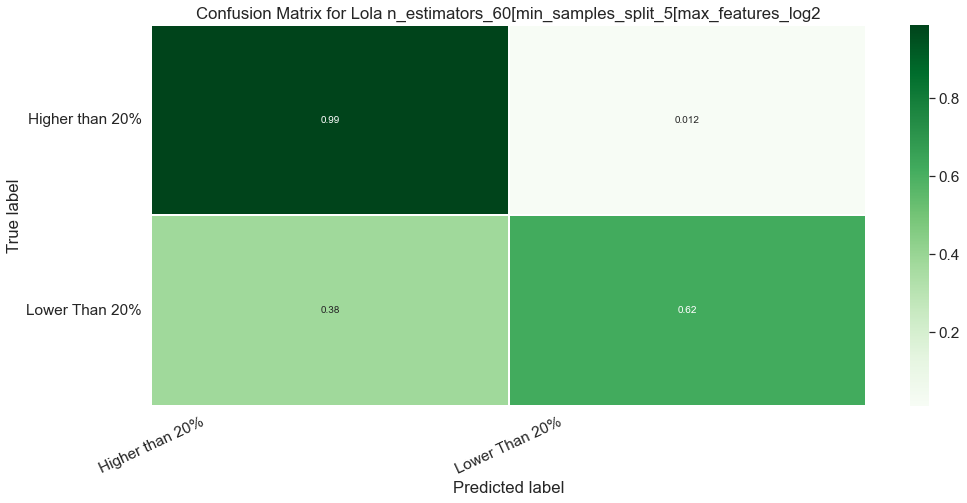

<AxesSubplot:>

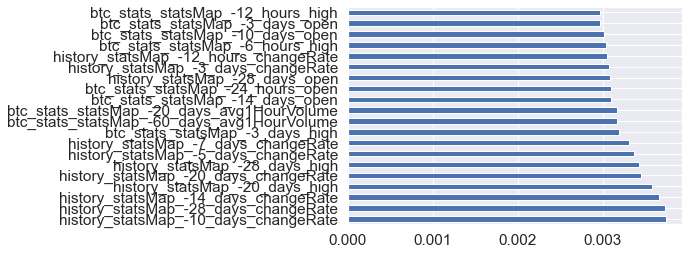

In [13]:
pars = {"n_estimators": 60,
 "min_samples_split": 5,
        "max_features": "log2"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

feat_importances = pd.Series(a1.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

Training model Lola n_estimators_60[min_samples_split_5[max_features_sqrt
Score 0.9341477381179615
Evaluating model Lola n_estimators_60[min_samples_split_5[max_features_sqrt
0.9341477381179615
[[4364   58]
 [ 287  530]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4422
           1       0.90      0.65      0.75       817

    accuracy                           0.93      5239
   macro avg       0.92      0.82      0.86      5239
weighted avg       0.93      0.93      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


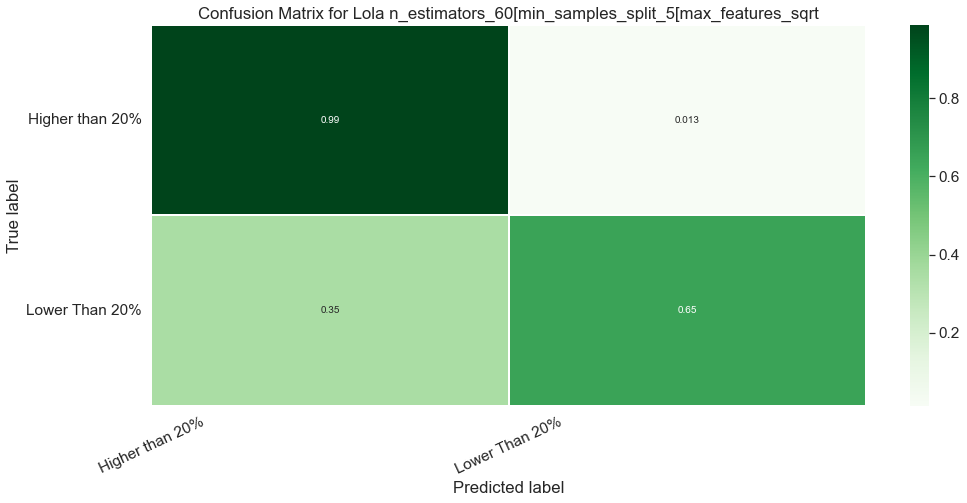

In [14]:
pars = {"n_estimators": 60,
 "min_samples_split": 5,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_50[min_samples_split_2[max_features_sqrt
Score 0.9375835083031113
Evaluating model Lola n_estimators_50[min_samples_split_2[max_features_sqrt
0.9375835083031113
[[4347   75]
 [ 252  565]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4422
           1       0.88      0.69      0.78       817

    accuracy                           0.94      5239
   macro avg       0.91      0.84      0.87      5239
weighted avg       0.94      0.94      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


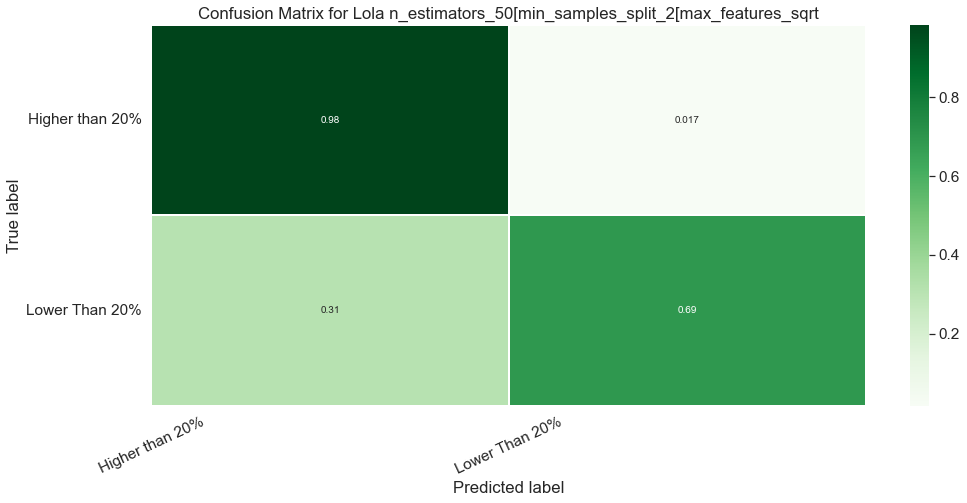

In [15]:
pars = {"n_estimators": 50,
 "min_samples_split": 2,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_500[min_samples_split_2[max_features_sqrt
Score 0.9377743844245084
Evaluating model Lola n_estimators_500[min_samples_split_2[max_features_sqrt
0.9377743844245084
[[4348   74]
 [ 252  565]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4422
           1       0.88      0.69      0.78       817

    accuracy                           0.94      5239
   macro avg       0.91      0.84      0.87      5239
weighted avg       0.94      0.94      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


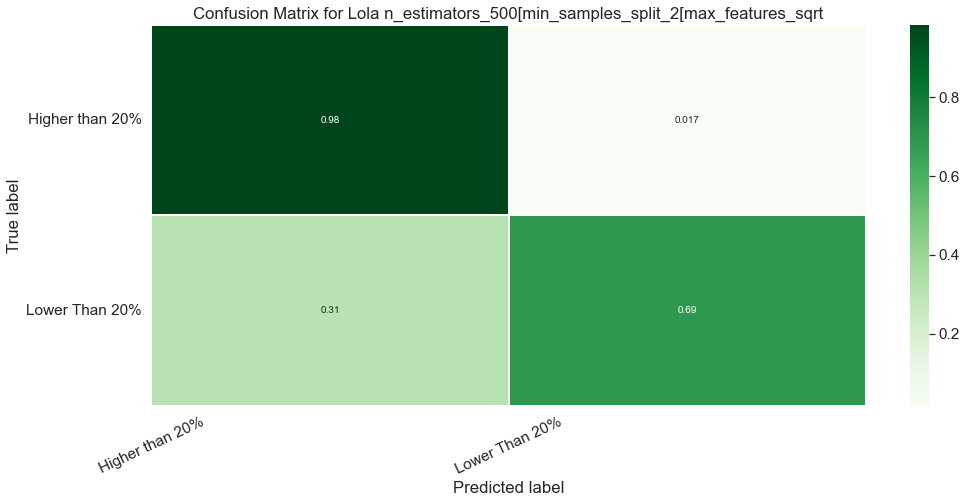

In [16]:
pars = {"n_estimators": 500,
 "min_samples_split": 2,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_10[min_samples_split_2[max_features_sqrt
Score 0.9330024813895782
Evaluating model Lola n_estimators_10[min_samples_split_2[max_features_sqrt
0.9330024813895782
[[4359   63]
 [ 288  529]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4422
           1       0.89      0.65      0.75       817

    accuracy                           0.93      5239
   macro avg       0.92      0.82      0.86      5239
weighted avg       0.93      0.93      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


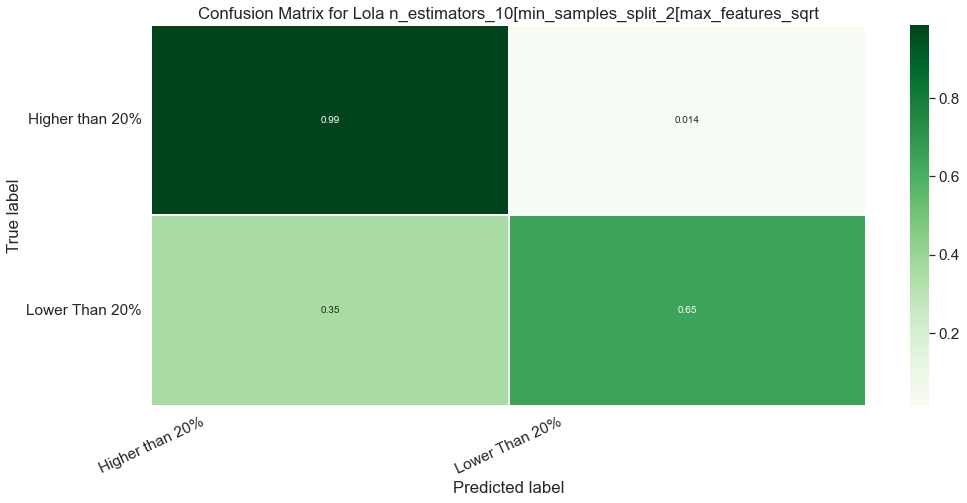

In [17]:
pars = {"n_estimators": 10,
 "min_samples_split": 2,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)

train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_222[min_samples_split_11[max_features_sqrt
Score 0.9261309410192785
Evaluating model Lola n_estimators_222[min_samples_split_11[max_features_sqrt
0.9261309410192785
[[4382   40]
 [ 347  470]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4422
           1       0.92      0.58      0.71       817

    accuracy                           0.93      5239
   macro avg       0.92      0.78      0.83      5239
weighted avg       0.93      0.93      0.92      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


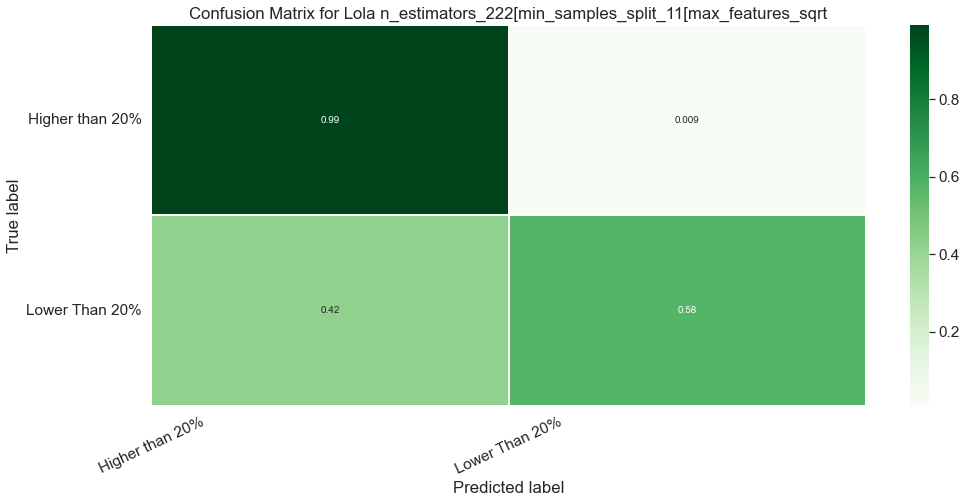

In [18]:
pars = {"n_estimators": 222,
 "min_samples_split": 11,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_1212[min_samples_split_87[max_features_log2
Score 0.8509257491887765
Evaluating model Lola n_estimators_1212[min_samples_split_87[max_features_log2
0.8509257491887765
[[4421    1]
 [ 780   37]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      4422
           1       0.97      0.05      0.09       817

    accuracy                           0.85      5239
   macro avg       0.91      0.52      0.50      5239
weighted avg       0.87      0.85      0.79      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


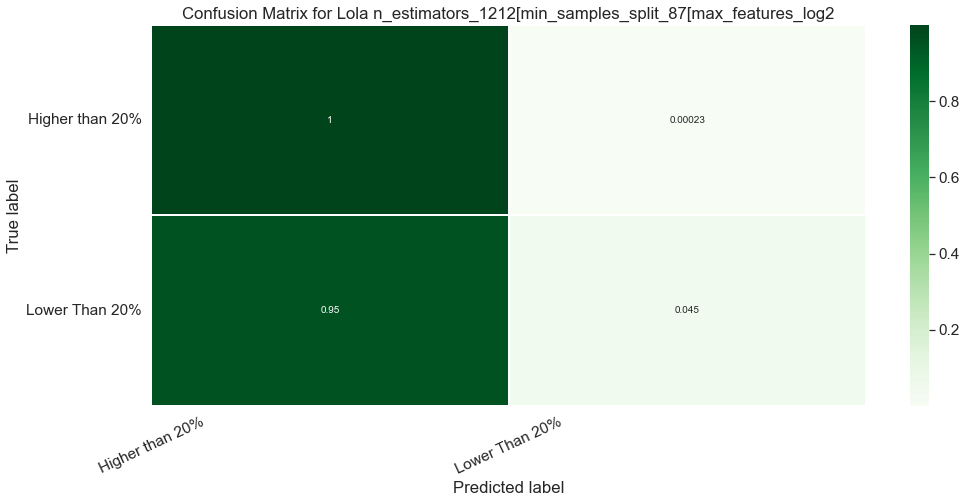

In [19]:
pars = {"n_estimators": 1212,
 "min_samples_split": 87,
 "max_features": "log2"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")


Training model Lola n_estimators_777[min_samples_split_6[max_features_log2
Score 0.9265126932620729
Evaluating model Lola n_estimators_777[min_samples_split_6[max_features_log2
0.9265126932620729
[[4373   49]
 [ 336  481]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4422
           1       0.91      0.59      0.71       817

    accuracy                           0.93      5239
   macro avg       0.92      0.79      0.84      5239
weighted avg       0.93      0.93      0.92      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


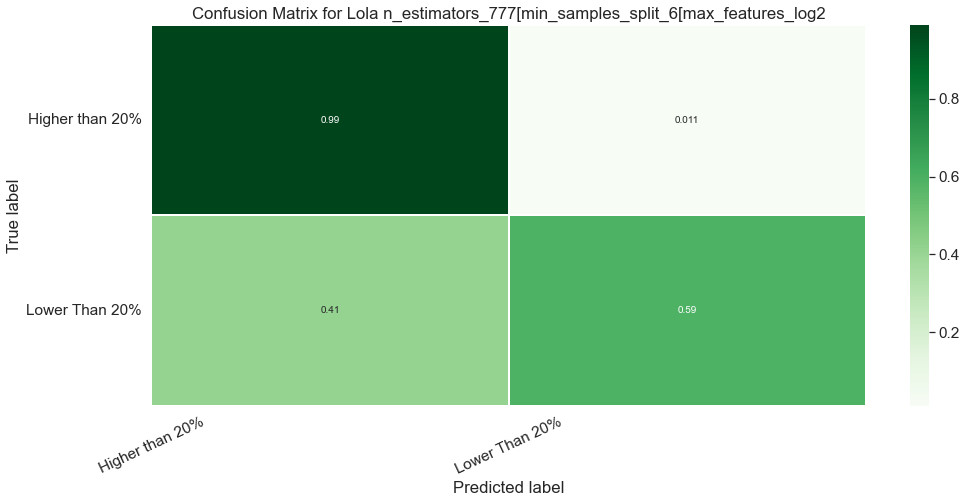

In [20]:
pars = {"n_estimators": 777,
 "min_samples_split": 6,
 "max_features": "log2"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")


Training model Lola n_estimators_100[min_samples_split_2[max_features_sqrt
Score 0.9381561366673029
Evaluating model Lola n_estimators_100[min_samples_split_2[max_features_sqrt
0.9381561366673029
[[4347   75]
 [ 249  568]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4422
           1       0.88      0.70      0.78       817

    accuracy                           0.94      5239
   macro avg       0.91      0.84      0.87      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


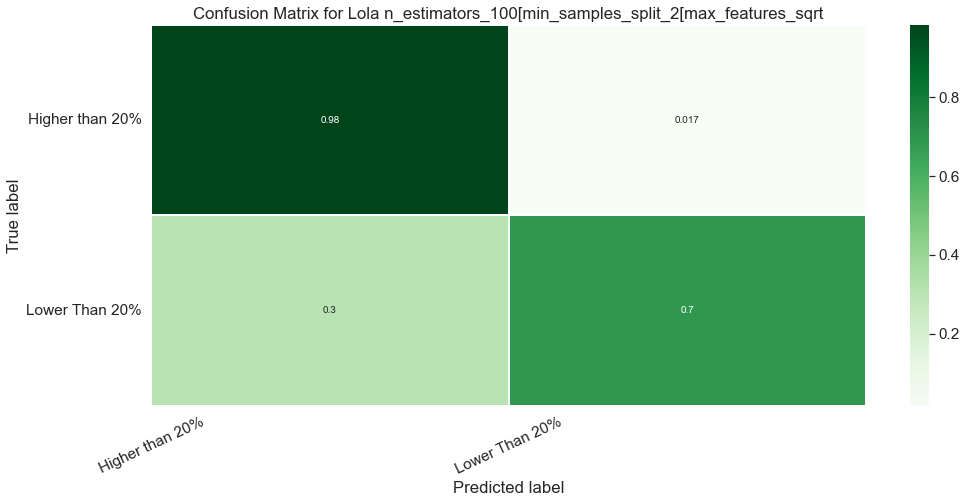

In [21]:
pars = {"n_estimators": 100,
 "min_samples_split": 2,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")


Training model Lola n_estimators_50[min_samples_split_2[min_samples_leaf_3[max_features_sqrt
Score 0.9240313036839092
Evaluating model Lola n_estimators_50[min_samples_split_2[min_samples_leaf_3[max_features_sqrt
0.9240313036839092
[[4375   47]
 [ 351  466]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4422
           1       0.91      0.57      0.70       817

    accuracy                           0.92      5239
   macro avg       0.92      0.78      0.83      5239
weighted avg       0.92      0.92      0.92      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


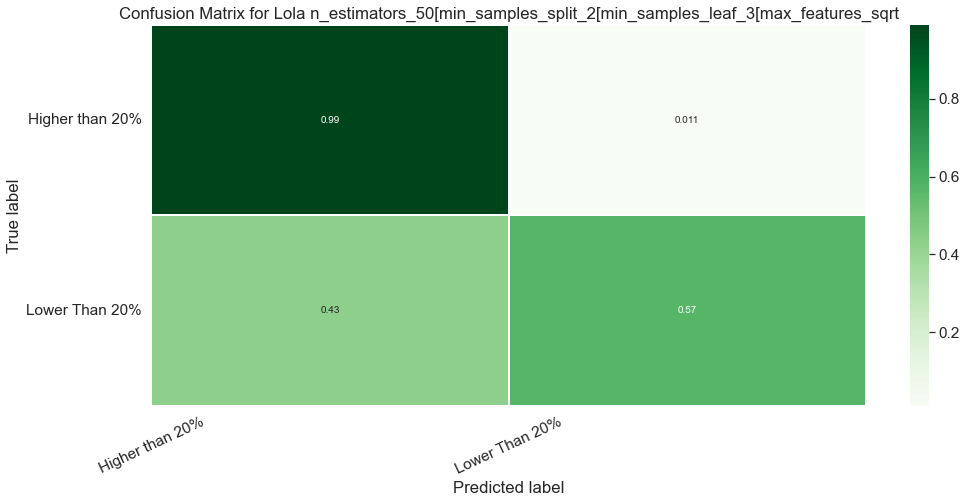

In [22]:
pars = {"n_estimators": 50,
 "min_samples_split": 2,
 "min_samples_leaf": 3,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_200[min_samples_split_3[min_samples_leaf_1[max_features_sqrt
Score 0.939110517274289
Evaluating model Lola n_estimators_200[min_samples_split_3[min_samples_leaf_1[max_features_sqrt
0.939110517274289
[[4352   70]
 [ 249  568]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4422
           1       0.89      0.70      0.78       817

    accuracy                           0.94      5239
   macro avg       0.92      0.84      0.87      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


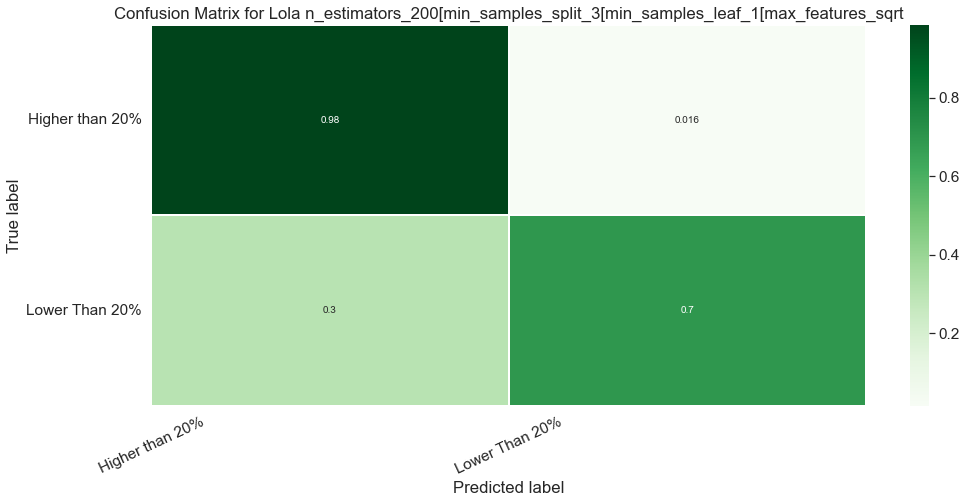

In [23]:
pars = {"n_estimators": 200,
 "min_samples_split": 3,
 "min_samples_leaf": 1,
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")



Training model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_balanced_subsample[max_features_sqrt
Score 0.9372017560603169
Evaluating model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_balanced_subsample[max_features_sqrt
0.9372017560603169
[[4352   70]
 [ 259  558]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4422
           1       0.89      0.68      0.77       817

    accuracy                           0.94      5239
   macro avg       0.92      0.83      0.87      5239
weighted avg       0.94      0.94      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


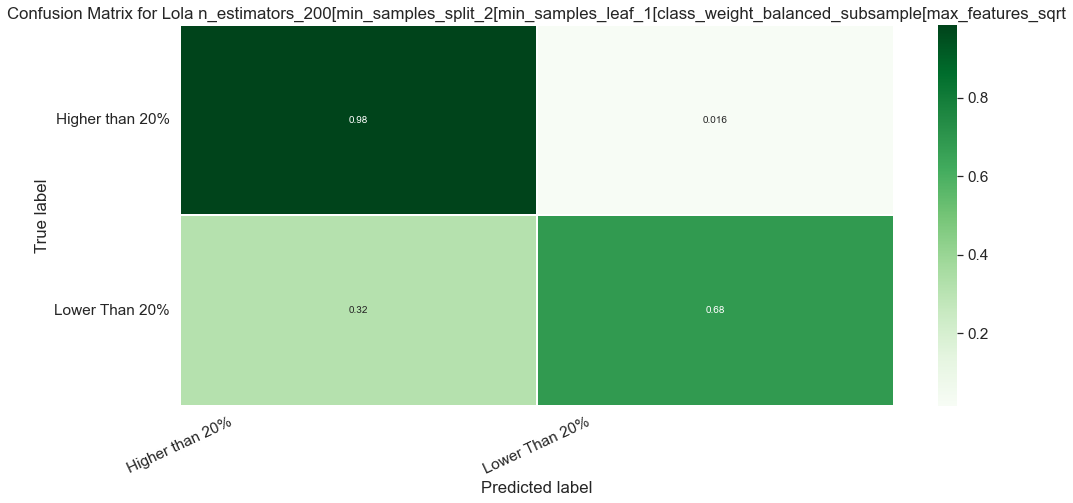

In [24]:
pars = {"n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 1,
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")





Training model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.2, 1: 0.8}[max_features_sqrt
Score 0.939110517274289
Evaluating model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.2, 1: 0.8}[max_features_sqrt
0.939110517274289
[[4351   71]
 [ 248  569]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4422
           1       0.89      0.70      0.78       817

    accuracy                           0.94      5239
   macro avg       0.92      0.84      0.87      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


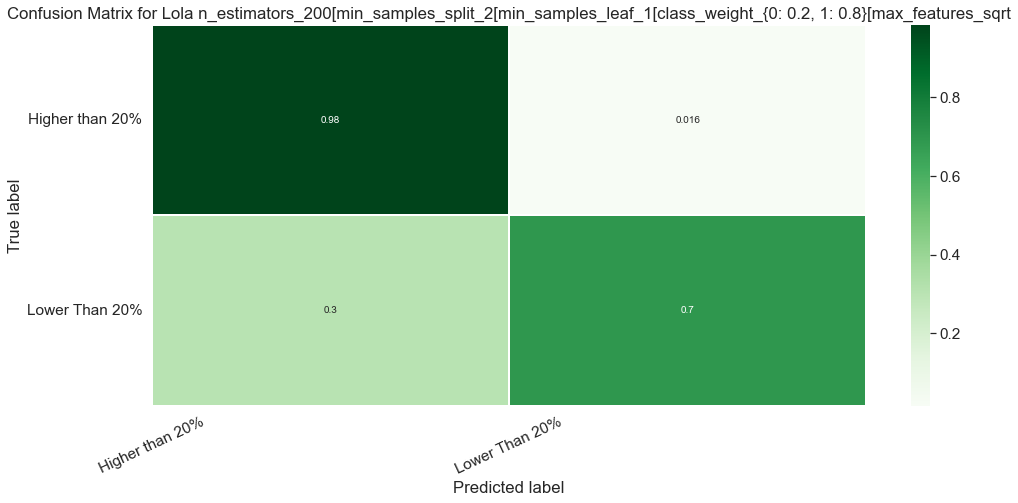

In [25]:
pars = {"n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 1,
"class_weight": {0:.2, 1:.8},
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")



Training model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.3, 1: 0.7}[max_features_sqrt
Score 0.9373926321817141
Evaluating model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.3, 1: 0.7}[max_features_sqrt
0.9373926321817141
[[4349   73]
 [ 255  562]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4422
           1       0.89      0.69      0.77       817

    accuracy                           0.94      5239
   macro avg       0.91      0.84      0.87      5239
weighted avg       0.94      0.94      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


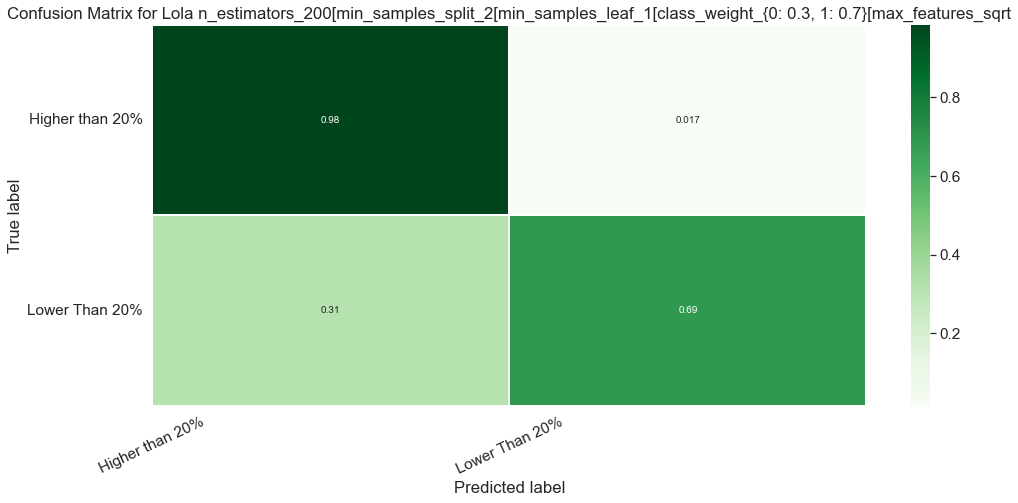

In [26]:
pars = {"n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 1,
"class_weight": {0:.3, 1:.7},
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")


Training model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.4, 1: 0.6}[max_features_sqrt
Score 0.9379652605459057
Evaluating model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.4, 1: 0.6}[max_features_sqrt
0.9379652605459057
[[4349   73]
 [ 252  565]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4422
           1       0.89      0.69      0.78       817

    accuracy                           0.94      5239
   macro avg       0.92      0.84      0.87      5239
weighted avg       0.94      0.94      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


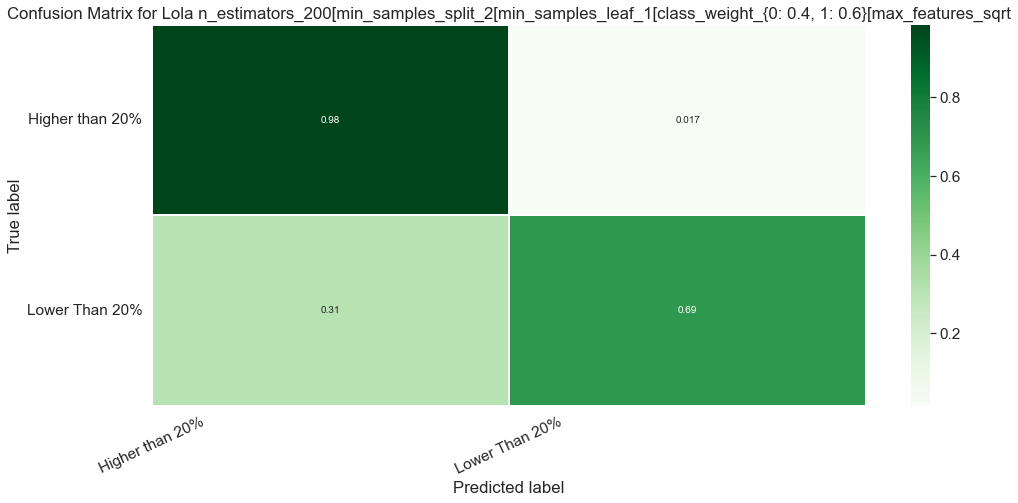

In [27]:
pars = {"n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 1,
"class_weight": {0:.4, 1:.6},
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")



Training model Lola n_estimators_300[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.4, 1: 0.6}[max_features_sqrt
Score 0.9398740217598779
Evaluating model Lola n_estimators_300[min_samples_split_2[min_samples_leaf_1[class_weight_{0: 0.4, 1: 0.6}[max_features_sqrt
0.9398740217598779
[[4354   68]
 [ 247  570]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4422
           1       0.89      0.70      0.78       817

    accuracy                           0.94      5239
   macro avg       0.92      0.84      0.87      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


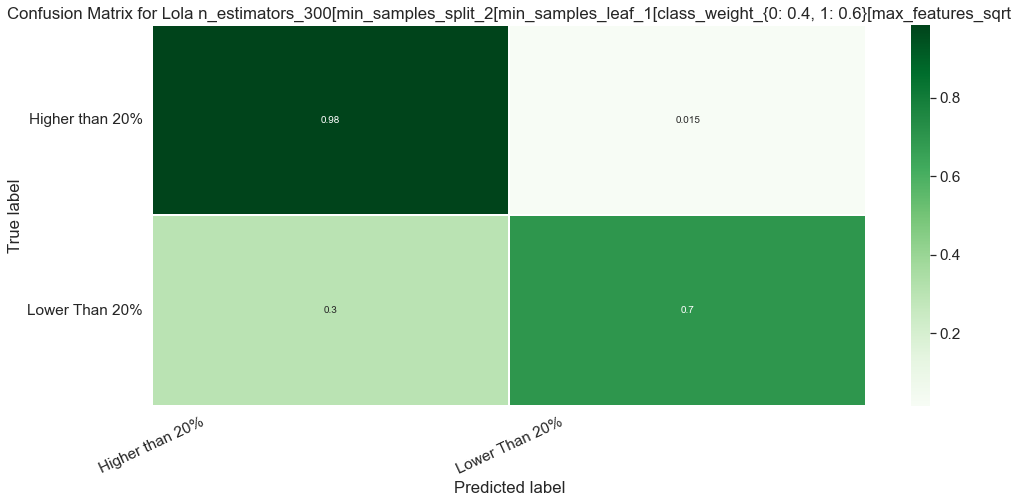

In [28]:
pars = {"n_estimators": 300,
 "min_samples_split": 2,
 "min_samples_leaf": 1,
"class_weight": {0:.4, 1:.6},
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_500[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
Score 0.9387287650314946
Evaluating model Lola n_estimators_500[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
0.9387287650314946
[[4331   91]
 [ 230  587]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4422
           1       0.87      0.72      0.79       817

    accuracy                           0.94      5239
   macro avg       0.91      0.85      0.87      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


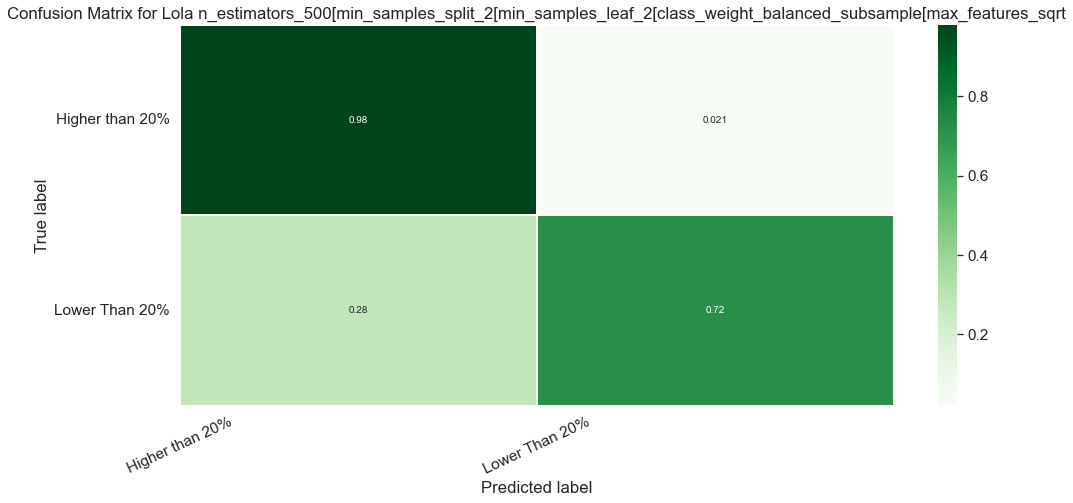

In [29]:
pars = {"n_estimators": 500,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")


Training model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
Score 0.9385378889100974
Evaluating model Lola n_estimators_200[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
0.9385378889100974
[[4324   98]
 [ 224  593]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4422
           1       0.86      0.73      0.79       817

    accuracy                           0.94      5239
   macro avg       0.90      0.85      0.88      5239
weighted avg       0.94      0.94      0.94      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


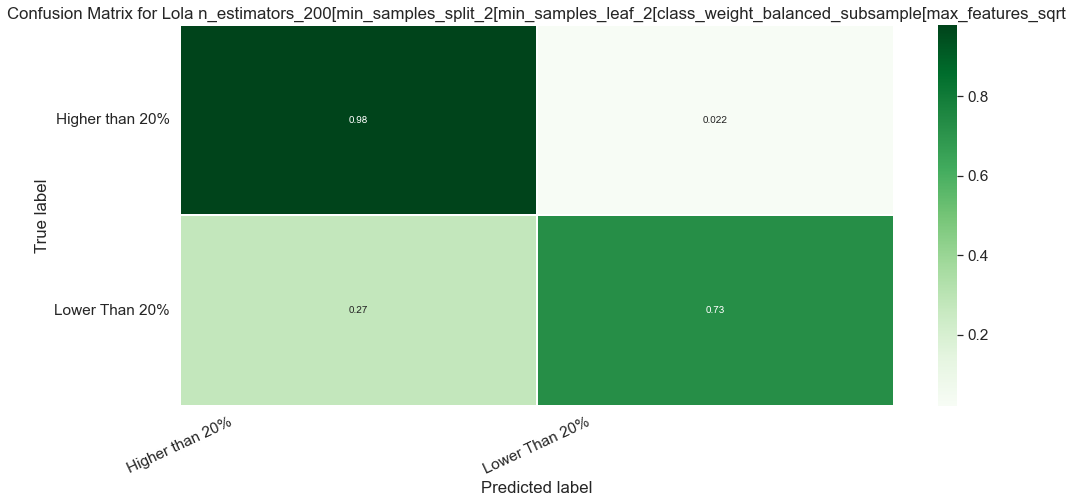

In [30]:
pars = {"n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_100[min_samples_split_2[max_features_sqrt[class_weight_balanced_subsample[random_state_10
Score 0.9375835083031113
Evaluating model Lola n_estimators_100[min_samples_split_2[max_features_sqrt[class_weight_balanced_subsample[random_state_10
0.9375835083031113
[[4355   67]
 [ 260  557]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4422
           1       0.89      0.68      0.77       817

    accuracy                           0.94      5239
   macro avg       0.92      0.83      0.87      5239
weighted avg       0.94      0.94      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


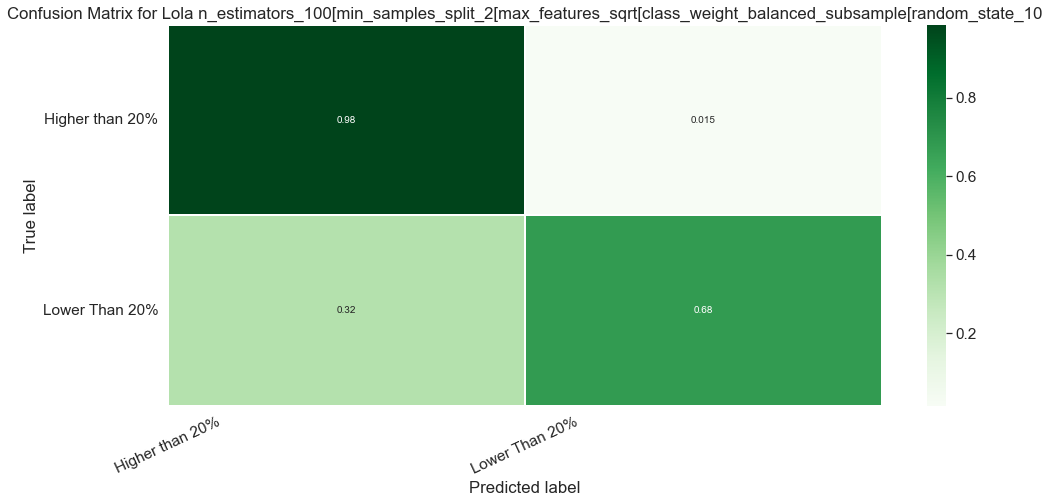

In [31]:
pars = {"n_estimators": 100,
 "min_samples_split": 2,
 "max_features": "sqrt",
"class_weight": 'balanced_subsample',
"random_state": 10
        }
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

Training model Lola n_estimators_100[min_samples_split_2[max_features_sqrt[class_weight_balanced_subsample[random_state_20
Score 0.9372017560603169
Evaluating model Lola n_estimators_100[min_samples_split_2[max_features_sqrt[class_weight_balanced_subsample[random_state_20
0.9372017560603169
[[4353   69]
 [ 260  557]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4422
           1       0.89      0.68      0.77       817

    accuracy                           0.94      5239
   macro avg       0.92      0.83      0.87      5239
weighted avg       0.94      0.94      0.93      5239



C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1308647180.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


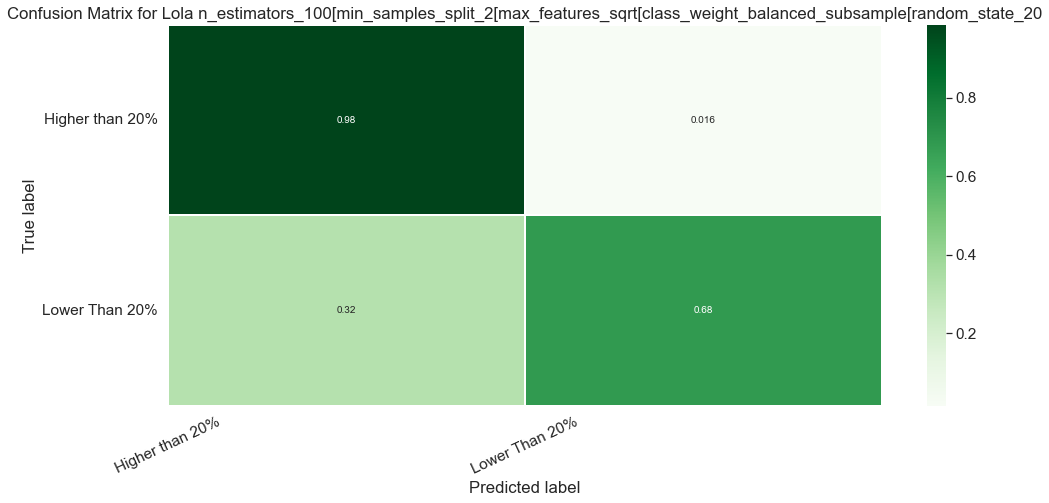

In [32]:
pars = {"n_estimators": 100,
 "min_samples_split": 2,
 "max_features": "sqrt",
"class_weight": 'balanced_subsample',
"random_state": 20
        }
a1 = ExtraTreesClassifier(**pars)
train_eval_model(x_test, y_test, a1, f"Lola {'['.join(f'{k}_{v}' for k, v in pars.items())}")

In [100]:
from model_factory import ModelFactory
_, y_class = ModelFactory.prepare_classification_label(y_down, -10)
y_class.value_counts()

In [101]:
d_x_train, d_x_test, d_y_train, d_y_test = train_test_split(x, y_class, test_size=0.1)

In [102]:

pars = {"n_estimators": 500,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
"class_weight": 'balanced_subsample',
 "max_features": "sqrt"}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(d_x_test, d_y_test, a1, f"RAGE {'['.join(f'{k}_{v}' for k, v in pars.items())}")

2022-07-15 11:58:02,013 - root - INFO - Creating label column up_50_return with threshold of 50
2022-07-15 11:58:02,017 - root - INFO - label_50_up
0              50238
1               2150
dtype: int64
C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Training model GIGA n_estimators_200[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
Score 0.8837564420690972
Evaluating model GIGA n_estimators_200[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
0.9875930521091811
[[5013   16]
 [  49  161]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5029
           1       0.91      0.77      0.83       210

    accuracy                           0.99      5239
   macro avg       0.95      0.88      0.91      5239
weighted avg       0.99      0.99      0.99      5239



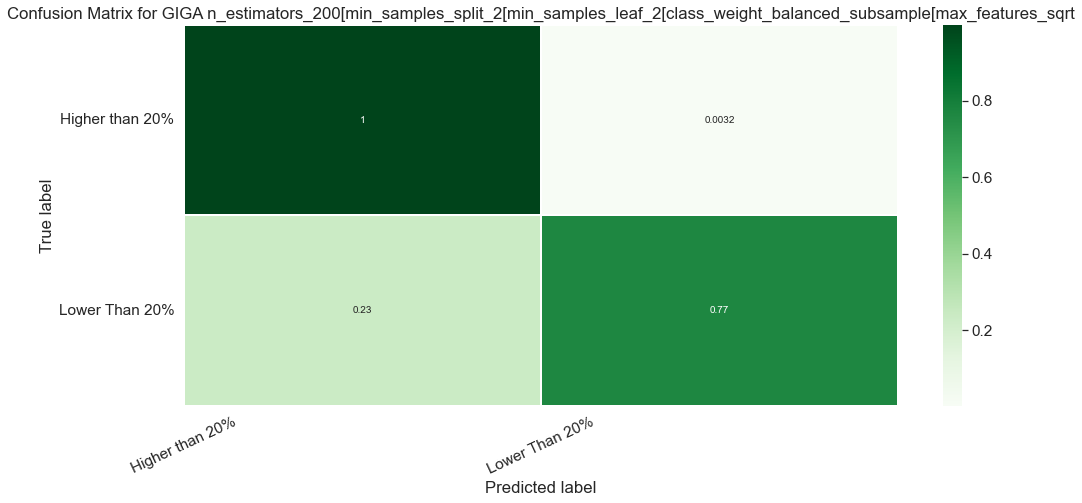

In [44]:
from model_factory import ModelFactory
label_cols = ['label_up_return', 'label_down_return']
_, y_class = ModelFactory.prepare_classification_label(df, 50)
x = df.drop(label_cols, axis=1)
y_class.value_counts()
d_x_train, d_x_test, d_y_train, d_y_test = train_test_split(x, y_class, test_size=0.1)
pars = {
 "n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
 "class_weight": 'balanced_subsample',
 "max_features": "sqrt"
}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(d_x_train, d_x_test, d_y_train, d_y_test, a1, name_model("GIGA", pars))

2022-07-15 11:59:05,365 - root - INFO - Creating label column up_80_return with threshold of 80
2022-07-15 11:59:05,370 - root - INFO - label_80_up
0              51431
1                957
dtype: int64
C:\Users\hustlestar\AppData\Local\Temp\ipykernel_20104\1133146516.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Training model GIGA n_estimators_200[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
Score 0.8606604313800343
Evaluating model GIGA n_estimators_200[min_samples_split_2[min_samples_leaf_2[class_weight_balanced_subsample[max_features_sqrt
0.9923649551441115
[[5128    7]
 [  33   71]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5135
           1       0.91      0.68      0.78       104

    accuracy                           0.99      5239
   macro avg       0.95      0.84      0.89      5239
weighted avg       0.99      0.99      0.99      5239



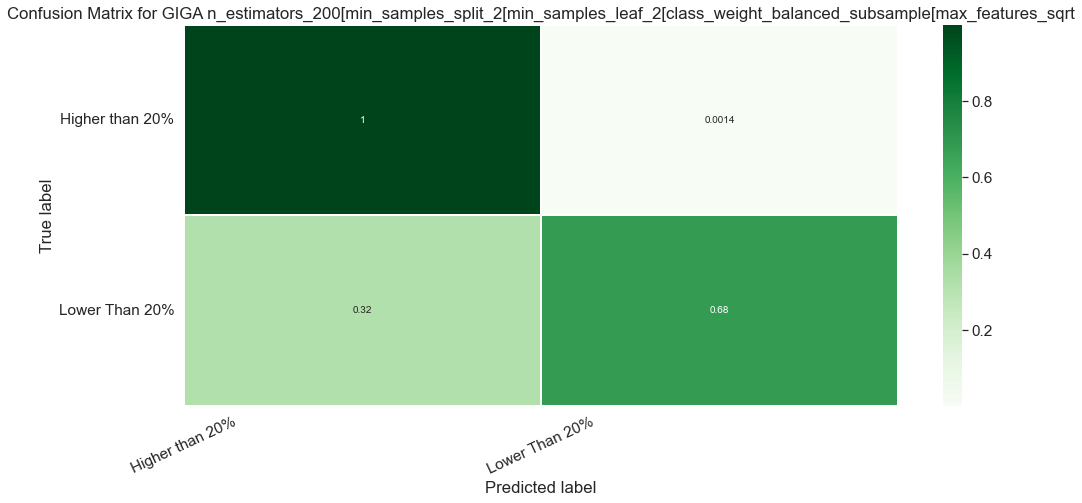

In [45]:
from model_factory import ModelFactory
label_cols = ['label_up_return', 'label_down_return']
label_col, y_class = ModelFactory.prepare_classification_label(df, 80)
x = df.drop(label_cols, axis=1)
y_class.value_counts()
d_x_train, d_x_test, d_y_train, d_y_test = train_test_split(x, y_class, test_size=0.1)
pars = {
 "n_estimators": 200,
 "min_samples_split": 2,
 "min_samples_leaf": 2,
 "class_weight": 'balanced_subsample',
 "max_features": "sqrt"
}
a1 = ExtraTreesClassifier(**pars)
train_eval_model(d_x_train, d_x_test, d_y_train, d_y_test, a1, name_model(f"GIGA {label_col}", pars))

